# Creating Regression Models to Predict Closing Price of NVDA
## Introduction to Machine Learning, Project 1
### Spencer Hirsch

## Problem Description

For Project 1 my goal is to accurately predict the stock price of Nvidia (NVDA) as it is a high performing stock in today's market. When I started working with machine learning last year, a project like this is something that I have been wanting to do and I thought this would be the perfect oppurtunity for me to work on it. 

Rather than just using the historical data for NVDA I will be using a variety of data that can influence the price. I collected data from the Down Jones Industrial Average (^DJI) and I manually calculated the Simple Moving Average of NVDA over a 5 day period as well as the Exponential Moving Average.

All of this data collection and processing resulted in a pandas dataframe that contained the following values: Date, NVDA_Open, NVDA_High, NVDA_Low, NVDA_Close, NVDA_Adj_Close, NVDA_Volume, NVDA_EMA_Daily_Avg, NVDA_SMA_Daily_Avg, DJIA_Open, DJIA_High, DJIA_Low, DJIA_Close, DJIA_Adj_Close, DJIA_Volume. 

Predicting stock price is a very difficult task to do, however, I had hopes that through the use of a variety of regression models I would be able to acheive results that would allow for the use of these models in real world applications. I have come to learn that the challenge was far more involved and difficult to acheive than I had originall thought. Thus, I used this project as more of an experiment to see what I would be able to acheive in accurate model performance.

#### Import Libraries used throughout project.

In [489]:
import sys
import warnings

import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


## Data Preparation

I collected data from Yahoo finance for this project, I originally was attempting to manually download the csv files for the data but I had run into some issues with collecting ^DJI data. I eventually found that there is a python library that allows you to load in data from yahoo finance into a csv.

Once this data was collected it was necessary for my to clean the data. Due to duplicate column names, such as 'Open', 'Close', etc. I made them more unique to avoid confusion. I also elimated duplicate columns such as 'Date' because both NVDA and ^DJI are read in from the same range.

In [256]:
'''
    For the end date you must chose n+1 because it will only include data
    up until this date.
'''

dji_data = yf.download('^DJI', start='1999-01-22', end='2024-03-21')
dji_data.to_csv("djia.csv")
print('DJIA data outputted to csv.')
dji_data = yf.download('NVDA', start='1999-01-22', end='2024-03-21')
dji_data.to_csv("nvda.csv")
print('NVDA data outputted to csv.')


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

DJIA data outputted to csv.
NVDA data outputted to csv.


In [490]:
nvda_file = 'nvda.csv'
dji_file = 'dji.csv'

nvda_df = pd.read_csv(nvda_file)
dji_df = pd.read_csv(dji_file)

dji_df = dji_df.drop(columns = ['Date']) # Drop duplicate column
# nvda_df = nvda_df.drop(columns = ['Adj Close']) # Drop duplicate csolumn

# Clean up column names to make it more descriptive.
nvda_df.rename(columns={'Open': 'NVDA_Open', 'High': 'NVDA_High', 'Low': 'NVDA_Low', 
                        'Close': 'NVDA_Close', 'Adj Close': 'NVDA_Adj_Close', 
                        'Volume': 'NVDA_Volume'}, inplace=True) 

dji_df.rename(columns={'Open': 'DJIA_Open', 'High': 'DJIA_High', 'Low': 'DJIA_Low', 
                       'Close': 'DJIA_Close', 'Adj Close': 'DJIA_Adj_Close', 
                       'Volume': 'DJIA_Volume'}, inplace=True) 

## Manually calulate metrics to include in data.

To add more features to the data I decided to add the Simple Moving Average and the Exponential Moving Average to reflect the movement in the price over a 5 day period. I chose this 5 day period as the market is open Monday through Friday with the exception of bank holidays. Calculating these metrics I believe should allow for short term trends to be more prevalent in the training data.

In [491]:
'''
    Calculate the Simple Moving Average (SMA) and the Exponential Moving Average (EMA)
    over a 5 day period in the data to indentify any short term trends.
'''

nvda_df['NVDA_SMA_Daily_Avg'] = nvda_df['NVDA_Close'].rolling(window=5).mean()
nvda_df['NVDA_EMA_Daily_Avg'] = nvda_df['NVDA_Close'].ewm(span=5, adjust=False).mean()

### NVDA Dataframe

In [492]:
nvda_df

,Date,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj_Close,NVDA_Volume,NVDA_SMA_Daily_Avg,NVDA_EMA_Daily_Avg
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800,NaN,0.410156
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000,NaN,0.424479
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000,NaN,0.422309
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800,NaN,0.420428
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000,0.422656,0.418741
...,...,...,...,...,...,...,...,...,...
6326,2024-03-14,895.770020,906.460022,866.000000,879.440002,879.440002,60231800,888.094006,888.767201
6327,2024-03-15,869.299988,895.460022,862.570007,878.369995,878.369995,64019300,888.712000,885.301466
6328,2024-03-18,903.880005,924.049988,870.849976,884.549988,884.549988,66897600,894.073999,885.050973
6329,2024-03-19,867.000000,905.440002,850.099976,893.979980,893.979980,67217100,889.043994,888.027309


### ^DJI Dataframe

In [263]:
dji_df

,DJIA_Open,DJIA_High,DJIA_Low,DJIA_Close,DJIA_Adj_Close,DJIA_Volume
0,9264.080078,9264.589844,9088.490234,9120.669922,9120.669922,93640000
1,9120.669922,9203.830078,9063.259766,9203.320312,9203.320312,89250000
2,9203.320312,9329.990234,9188.379883,9324.580078,9324.580078,90780000
3,9325.360352,9385.860352,9195.339844,9200.230469,9200.230469,88800000
4,9203.570312,9301.150391,9203.570312,9281.330078,9281.330078,80490000
...,...,...,...,...,...,...
6326,39122.390625,39160.250000,38704.359375,38905.660156,38905.660156,375810000
6327,38809.648438,38928.128906,38618.199219,38714.769531,38714.769531,774360000
6328,38826.929688,38898.410156,38760.789062,38790.429688,38790.429688,327950000
6329,38819.609375,39122.710938,38761.281250,39110.761719,39110.761719,310610000


### Combine dataframes

After constructing the two individual dataframes, I combined them into one single dataframe for the models to eventually use. I then export this to a csv for the models to pull the data and process them individually if necessary.

In [264]:
combined_df = pd.concat([nvda_df, dji_df], axis=1)
combined_df.to_csv('combined.csv', index=False)  
combined_df

,Date,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Volume,NVDA_SMA_Daily_Avg,NVDA_EMA_Daily_Avg,DJIA_Open,DJIA_High,DJIA_Low,DJIA_Close,DJIA_Adj_Close,DJIA_Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,271468800,NaN,0.410156,9264.080078,9264.589844,9088.490234,9120.669922,9120.669922,93640000
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,51048000,NaN,0.424479,9120.669922,9203.830078,9063.259766,9203.320312,9203.320312,89250000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,34320000,NaN,0.422309,9203.320312,9329.990234,9188.379883,9324.580078,9324.580078,90780000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,24436800,NaN,0.420428,9325.360352,9385.860352,9195.339844,9200.230469,9200.230469,88800000
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,22752000,0.422656,0.418741,9203.570312,9301.150391,9203.570312,9281.330078,9281.330078,80490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6326,2024-03-14,895.770020,906.460022,866.000000,879.440002,60231800,888.094006,888.767201,39122.390625,39160.250000,38704.359375,38905.660156,38905.660156,375810000
6327,2024-03-15,869.299988,895.460022,862.570007,878.369995,64019300,888.712000,885.301466,38809.648438,38928.128906,38618.199219,38714.769531,38714.769531,774360000
6328,2024-03-18,903.880005,924.049988,870.849976,884.549988,66897600,894.073999,885.050973,38826.929688,38898.410156,38760.789062,38790.429688,38790.429688,327950000
6329,2024-03-19,867.000000,905.440002,850.099976,893.979980,67217100,889.043994,888.027309,38819.609375,39122.710938,38761.281250,39110.761719,39110.761719,310610000


## Initial Data Visualization

Text(0, 0.5, 'Price ($)')

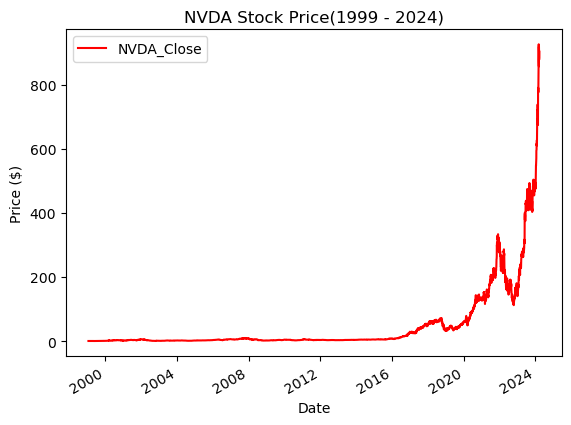

In [503]:
data = pd.read_csv('combined.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.plot(x='Date', y='NVDA_Open', kind='line', color='red')
plt.title('NVDA Stock Price(1999 - 2024)')
plt.ylabel('Price ($)')

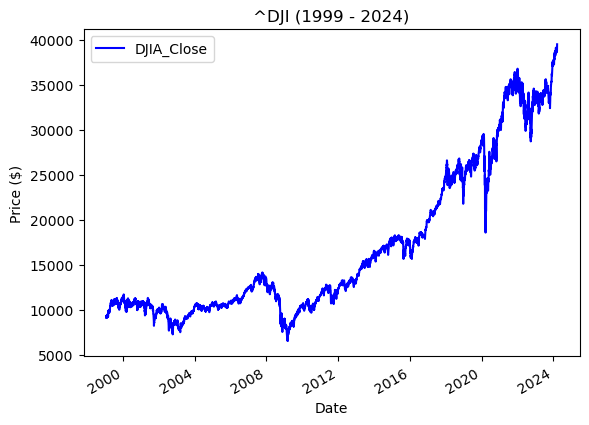

In [504]:
data = pd.read_csv('combined.csv')
data['Date'] = pd.to_datetime(data['Date'])

data.plot(x='Date', y='DJIA_Close', kind='line', color='blue')
plt.title('^DJI (1999 - 2024)')
plt.ylabel('Price ($)')
plt.show()

## Training Linear Regression Model

In [360]:
lr_model = LinearRegression()
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
lr_model.fit(train_x, train_y)

predictions = lr_model.predict(test_x)

print('We can see some clear overfitting with the following results:\n')
print('The r^2 score is', r2_score(test_y, predictions))
print('The mean squared error is', mean_squared_error(test_y, predictions))
print('The mean absolute error is', mean_absolute_error(test_y, predictions))

We can see some clear overfitting with the following results:

The r^2 score is 0.9998705304728243
The mean squared error is 1.3497416140509602
The mean absolute error is 0.4454123546255314


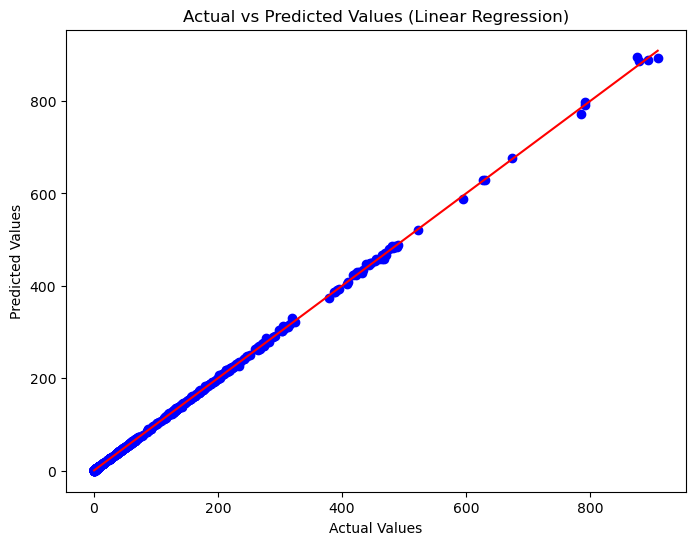

In [274]:
plt.figure(figsize=(8, 6))
plt.scatter(test_y, predictions, color='blue')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.show()

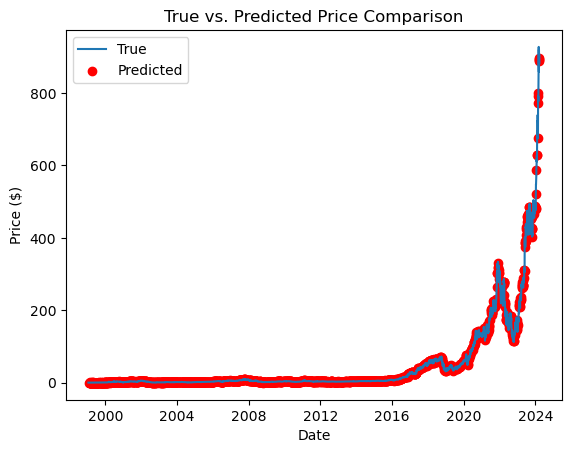

In [386]:
plt.plot(data['Date'], data['NVDA_Close'], label='True')
df = pd.DataFrame(test_x)
df[0] = pd.to_datetime(df[0], format='%Y%m%d')
plt.scatter(df[0], predictions, color='red', label='Predicted')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title('True vs. Predicted Price Comparison')
plt.legend()
plt.show()

## Training ARIMA Model

Mean Squared Error (RMSE): 54022.52714574289


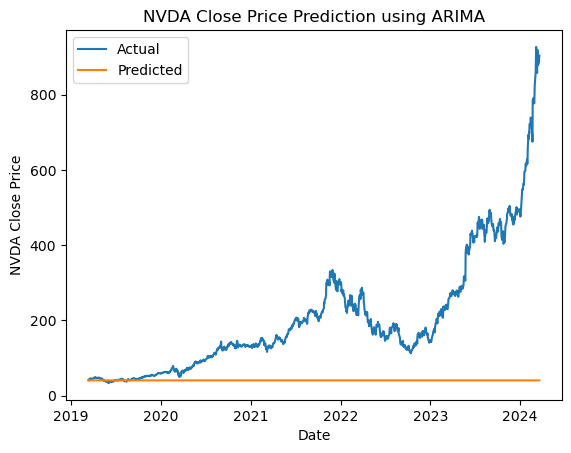

In [436]:
from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv('combined.csv')[4::]

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

model = ARIMA(train['NVDA_Close'], order=(1, 1, 1))
fitted = model.fit()

predictions = fitted.forecast(steps=len(test))

mse = mean_squared_error(test['NVDA_Close'], predictions)
print(f'Mean Squared Error (RMSE): {mse}')

test.index = pd.to_datetime(test.index.astype(str))
# Plot actual vs predicted
plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction using ARIMA')
plt.legend()
plt.show()


Best Mean Squared Error (MSE): 45633.320650188885
Best P: 1, Best D: 3, Best Q: 3


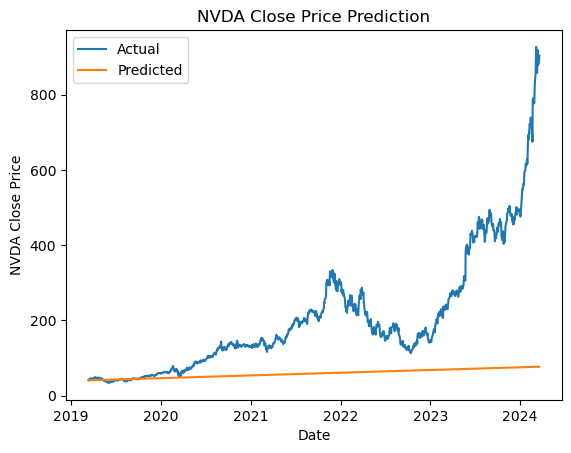

In [444]:
warnings.filterwarnings("ignore")

data = pd.read_csv('combined.csv')[4::]

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

p_vals = range(0, 4)
d_vals = range(0, 4)
q_vals = range(0, 4)

best_params = None
best_preds = None
best_mse = sys.maxsize

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            model = ARIMA(train['NVDA_Close'], order=(p, d, q))
            arima_model = model.fit()

            predictions = arima_model.forecast(steps=len(test))

            mse = mean_squared_error(test['NVDA_Close'], predictions)
            if mse < best_mse:
                best_mse = mse
                best_params = [p, d, q]
                best_preds = predictions
print(f'Best Mean Squared Error (MSE): {best_mse}')
print(f'Best P: {best_params[0]}, Best D: {best_params[1]}, Best Q: {best_params[2]}')

test.index = pd.to_datetime(test.index.astype(str))

plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, best_preds, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction')
plt.legend()
plt.show()


Mean Squared Error (RMSE): 36175.046976919584


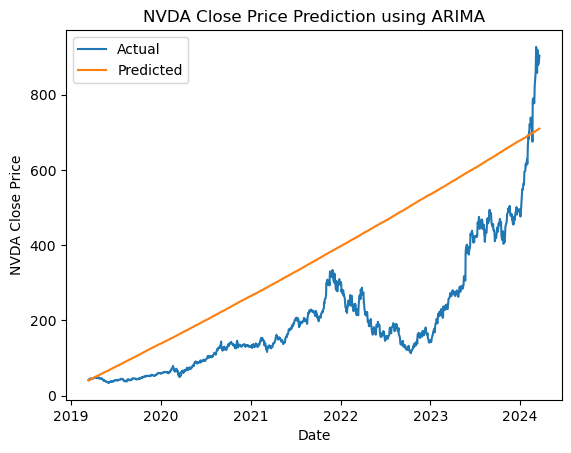

In [445]:
data = pd.read_csv('combined.csv')[4::]

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

model = ARIMA(train['NVDA_Close'], order=(7, 3, 2))
fitted = model.fit()

predictions = fitted.forecast(steps=len(test))

mse = mean_squared_error(test['NVDA_Close'], predictions)
print(f'Mean Squared Error (RMSE): {mse}')

test.index = pd.to_datetime(test.index.astype(str))
# Plot actual vs predicted
plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction using ARIMA')
plt.legend()
plt.show()


Mean Squared Error (RMSE): 34813.61209176357


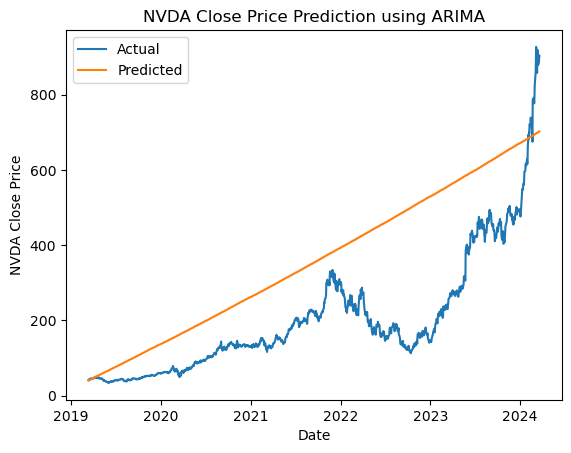

In [460]:
from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv('combined.csv')[4::]

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

model = ARIMA(train['NVDA_Close'], order=(7, 3, 2))
fitted = model.fit()

predictions = fitted.forecast(steps=len(test))

mse = mean_squared_error(test['NVDA_Close'], predictions)
print(f'Mean Squared Error (RMSE): {mse}')

test.index = pd.to_datetime(test.index.astype(str))
# Plot actual vs predicted
plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction using ARIMA')
plt.legend()
plt.show()


## Training GARCH Model

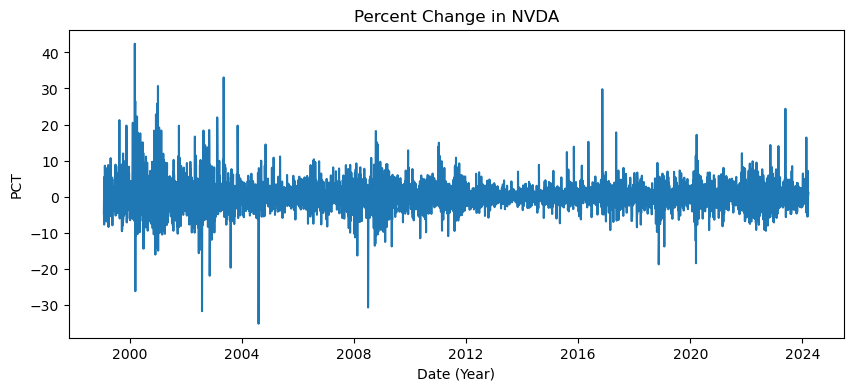

In [468]:
returns = 100 * data['NVDA_Close'].pct_change().dropna()
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.title('Percent Change in NVDA')
plt.xlabel('Date (Year)')
plt.ylabel('PCT')
plt.show()

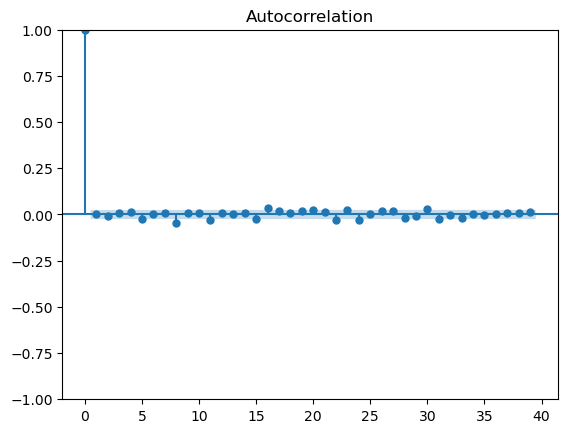

In [469]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(returns)
plt.show()

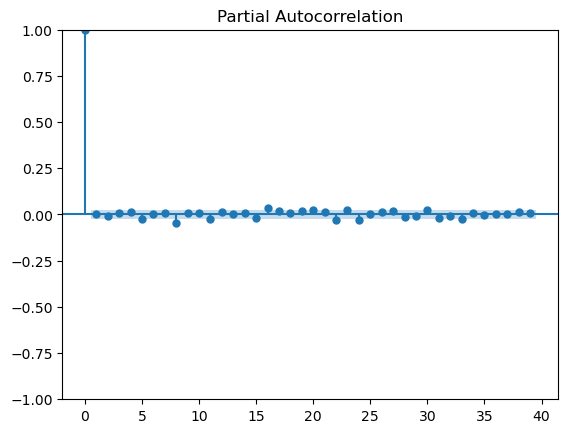

In [470]:
plot_pacf(returns)
plt.show()

In [471]:
from arch import arch_model

garch_model = arch_model(returns, vol='GARCH', p=1, q=1, rescale=True)
garch_trained = garch_model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 46098.32844518074
Iteration:      2,   Func. Count:     16,   Neg. LLF: 93108950022.12227
Iteration:      3,   Func. Count:     24,   Neg. LLF: 15825524.45288457
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16657.37927318525
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16527.990463709415
Iteration:      6,   Func. Count:     41,   Neg. LLF: 972499.6265342092
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17719.11183253435
Iteration:      8,   Func. Count:     55,   Neg. LLF: 27422.977826717157
Iteration:      9,   Func. Count:     61,   Neg. LLF: 16523.179591000284
Iteration:     10,   Func. Count:     66,   Neg. LLF: 16523.085924322462
Iteration:     11,   Func. Count:     71,   Neg. LLF: 16523.062054418784
Iteration:     12,   Func. Count:     76,   Neg. LLF: 16523.061645414
Iteration:     13,   Func. Count:     81,   Neg. LLF: 16523.061589499488
Iteration:     14,   Func. Count:     86,   Neg. LLF: 16523.

In [472]:
garch_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16523.1
Distribution:                  Normal   AIC:                           33054.1
Method:            Maximum Likelihood   BIC:                           33081.1
                                        No. Observations:                 6326
Date:                Sat, Mar 30 2024   Df Residuals:                     6325
Time:                        21:01:40   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2314  5.410e-02      4.277  1.893e-05 [  0.125,  0.337]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0981      0.209      0.470      0.638    [ -0.311,  0.507]
alpha[1]       0.0474  6.631e-02      0.714      0.475 [-8.259e-02,  0.177]
beta[1]        0.9479  7.523e-02     12.600  2.114e-36    [  0.800,  1.095]
===========================================================================

Covariance estimator: robust
"""

In [478]:
garch_model = arch_model(returns, vol='GARCH', p=1, q=2, rescale=True)
garch_trained = garch_model.fit()
garch_trained.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 42448.061676600955
Iteration:      2,   Func. Count:     17,   Neg. LLF: 34869.88968937442
Iteration:      3,   Func. Count:     26,   Neg. LLF: 16641.771839882385
Iteration:      4,   Func. Count:     33,   Neg. LLF: 16576.765642942526
Iteration:      5,   Func. Count:     40,   Neg. LLF: 16704.774172656664
Iteration:      6,   Func. Count:     47,   Neg. LLF: 16525.056096209384
Iteration:      7,   Func. Count:     54,   Neg. LLF: 16587.384896401294
Iteration:      8,   Func. Count:     61,   Neg. LLF: 16563.761668054896
Iteration:      9,   Func. Count:     68,   Neg. LLF: 21562.50111685867
Iteration:     10,   Func. Count:     76,   Neg. LLF: 16520.79455867465
Iteration:     11,   Func. Count:     82,   Neg. LLF: 16520.663329737094
Iteration:     12,   Func. Count:     88,   Neg. LLF: 16520.65315137923
Iteration:     13,   Func. Count:     94,   Neg. LLF: 16520.65262139211
Iteration:     14,   Func. Count:    100,   Neg. LLF: 16

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16520.7
Distribution:                  Normal   AIC:                           33051.3
Method:            Maximum Likelihood   BIC:                           33085.1
                                        No. Observations:                 6326
Date:                Sat, Mar 30 2024   Df Residuals:                     6325
Time:                        21:04:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2335  5.119e-02      4.562  5.077e-06 [  0.133,  0.334]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1259      0.207      0.608      0.543    [ -0.280,  0.532]
alpha[1]       0.0648  6.754e-02      0.959      0.338 [-6.762e-02,  0.197]
beta[1]        0.4568      0.234      1.953  5.087e-02 [-1.721e-03,  0.915]
beta[2]        0.4725      0.224      2.107  3.509e-02  [3.304e-02,  0.912]
===========================================================================

Covariance estimator: robust
"""

In [488]:
forecasts = garch_trained.forecast()
forecasted_volatility = forecasts.variance['h.1'].values

actual_volatility = returns ** 2

mse = mean_squared_error(actual_volatility[-len(forecasted_volatility):], forecasted_volatility)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 225.11455835150505


### Tuning GARCH Model



In [487]:
p_vals= range(1, 5)
q_vals = range(1, 5)

best_garch_trained = None
best_mse = sys.maxsize
best_vals = [0, 0]
for p_val in p_vals:
    for q_val in q_vals:
        garch_model = arch_model(returns, vol='GARCH', p=p_val, q=q_val, rescale=True)
        garch_trained = garch_model.fit()
        forecasts = garch_trained.forecast()
        forecasted_volatility = forecasts.variance['h.1'].values
        actual_volatility = returns ** 2
        mse = mean_squared_error(actual_volatility[-len(forecasted_volatility):], forecasted_volatility)
        if mse < best_mse:
            best_mse = mse
            best_garch_trained = garch_trained
            best_vals = [p_val, q_val]

print("Mean Squared Error (MSE):", best_mse)
print(f"Best P: {best_vals[0]}, Best Q: {best_vals[1]}")
best_garch_trained.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46098.32844518074
Iteration:      2,   Func. Count:     16,   Neg. LLF: 93108950022.12227
Iteration:      3,   Func. Count:     24,   Neg. LLF: 15825524.45288457
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16657.37927318525
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16527.990463709415
Iteration:      6,   Func. Count:     41,   Neg. LLF: 972499.6265342092
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17719.11183253435
Iteration:      8,   Func. Count:     55,   Neg. LLF: 27422.977826717157
Iteration:      9,   Func. Count:     61,   Neg. LLF: 16523.179591000284
Iteration:     10,   Func. Count:     66,   Neg. LLF: 16523.085924322462
Iteration:     11,   Func. Count:     71,   Neg. LLF: 16523.062054418784
Iteration:     12,   Func. Count:     76,   Neg. LLF: 16523.061645414
Iteration:     13,   Func. Count:     81,   Neg. LLF: 16523.061589499488
Iteration:     14,   Func. Count:     86,   Neg. LLF: 16523.

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16517.3
Distribution:                  Normal   AIC:                           33048.6
Method:            Maximum Likelihood   BIC:                           33095.9
                                        No. Observations:                 6326
Date:                Sat, Mar 30 2024   Df Residuals:                     6325
Time:                        22:04:16   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2305  4.609e-02      5.001  5.700e-07 [  0.140,  0.321]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1528      0.184      0.831      0.406    [ -0.207,  0.513]
alpha[1]       0.0919  6.820e-02      1.348      0.178 [-4.173e-02,  0.226]
beta[1]        0.2285      0.249      0.918      0.358    [ -0.259,  0.716]
beta[2]        0.1014      0.330      0.307      0.759    [ -0.546,  0.748]
beta[3]        0.3789      0.394      0.962      0.336    [ -0.393,  1.151]
beta[4]        0.1929      0.246      0.784      0.433    [ -0.290,  0.675]
===========================================================================

Covariance estimator: robust
"""